# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
train = pd.read_csv('../dataset/Predicting Employee Attrition/train_data.csv')

In [5]:
train.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


In [7]:
train['MMM-YY'].describe()

count          19104
unique            24
top       2016-01-01
freq            1022
Name: MMM-YY, dtype: object

In [8]:
train['MMM-YY'] = pd.to_datetime(train['MMM-YY'])
train['Dateofjoining'] = pd.to_datetime(train['Dateofjoining'])
train['LastWorkingDate'] = pd.to_datetime(train['LastWorkingDate'])

# Feature Engineering

In [9]:
uniqueemployeesdata= train[['Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Dateofjoining', 'Joining Designation','Designation']].drop_duplicates()

In [10]:
# get the target column set
employeeswholeft = train[~train['LastWorkingDate'].isna()]
employeeswholeft['Y']=0
uniqueemployeesdata = uniqueemployeesdata.merge(employeeswholeft[['Emp_ID','Y']],on='Emp_ID',how='left')
uniqueemployeesdata['Y']=uniqueemployeesdata['Y'].fillna(1)

In [11]:
employeeage = train.groupby('Emp_ID').count()['City']
employeeage = employeeage.reset_index()
employeeage.columns = ['Emp_ID','Periodwithus']
uniqueemployeesdata=  uniqueemployeesdata.merge(employeeage,on='Emp_ID',how='left')

In [12]:
uniqueemployeesdata = uniqueemployeesdata.merge(pd.pivot_table(train,index='Emp_ID',values=['Total Business Value','Quarterly Rating'],aggfunc='mean').reset_index(),on='Emp_ID',how='left')

In [13]:
# time business done
uniqueemployeesdata['timesbusinessdone'] = uniqueemployeesdata['Total Business Value']/uniqueemployeesdata['Salary']

In [14]:
# reversal happend for employees
reversals = train[train['Total Business Value']<0]
reversals['reversal']=1
uniqueemployeesdata=uniqueemployeesdata.merge(reversals[['Emp_ID','reversal']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['reversal']=uniqueemployeesdata['reversal'].fillna(0)

In [15]:
# zero business count
zeroperformance = train[train['Total Business Value']==0]
zeroperformance = zeroperformance.groupby('Emp_ID').count()['Age'].reset_index()
zeroperformance.columns = ['Emp_ID','zeroperformance']
uniqueemployeesdata = uniqueemployeesdata.merge(zeroperformance.drop_duplicates(),on='Emp_ID',how='left')

In [16]:
# months where coverage less than salary
train['timesbusiness'] = train['Total Business Value']/train['Salary']
businesslesscoverage = train[train['timesbusiness']<1]
businesslesscoverage=businesslesscoverage.groupby('Emp_ID').count()['Age'].reset_index()
businesslesscoverage.columns=['Emp_ID','Businesslessthansalary']
uniqueemployeesdata=uniqueemployeesdata.merge(businesslesscoverage[['Emp_ID','Businesslessthansalary']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['Businesslessthansalary']=uniqueemployeesdata['Businesslessthansalary'].fillna(0)

In [17]:
# Change in designation
changedesignation = train[train['Joining Designation'] != train['Designation']]
changedesignation['changedesignation']=1
changedesignation = changedesignation[['Emp_ID','changedesignation']].drop_duplicates()
uniqueemployeesdata = uniqueemployeesdata.merge(changedesignation[['Emp_ID','changedesignation']].drop_duplicates(),on='Emp_ID',how='left')
uniqueemployeesdata['changedesignation'] = uniqueemployeesdata['changedesignation'].fillna(0)

In [18]:
# Last rating before leaving
lastrating = train[['Emp_ID','Quarterly Rating']].drop_duplicates( subset='Emp_ID',keep='last')
lastrating.columns = ['Emp_ID','Last Rating']
uniqueemployeesdata = uniqueemployeesdata.merge(lastrating,on='Emp_ID',how='left')

In [19]:
uniqueemployeesdata.head()

,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,Joining Designation,Designation,Y,Periodwithus,Quarterly Rating,Total Business Value,timesbusinessdone,reversal,zeroperformance,Businesslessthansalary,changedesignation,Last Rating
0,1,28,Male,C23,Master,57387,2015-12-24,1,1,0.0,3,2.0,571860.0,9.964975,1.0,1.0,2.0,0.0,2
1,2,31,Male,C7,Master,67016,2017-11-06,2,2,1.0,2,1.0,0.0,0.000000,0.0,2.0,2.0,0.0,1
2,4,43,Male,C13,Master,65603,2016-12-07,2,2,0.0,5,1.0,70000.0,1.067024,0.0,4.0,4.0,0.0,1
3,5,29,Male,C9,College,46368,2016-01-09,1,1,0.0,3,1.0,40120.0,0.865252,0.0,2.0,2.0,0.0,1
4,6,31,Female,C11,Bachelor,78728,2017-07-31,3,3,1.0,5,1.6,253000.0,3.213596,0.0,4.0,4.0,0.0,2


<Axes: >

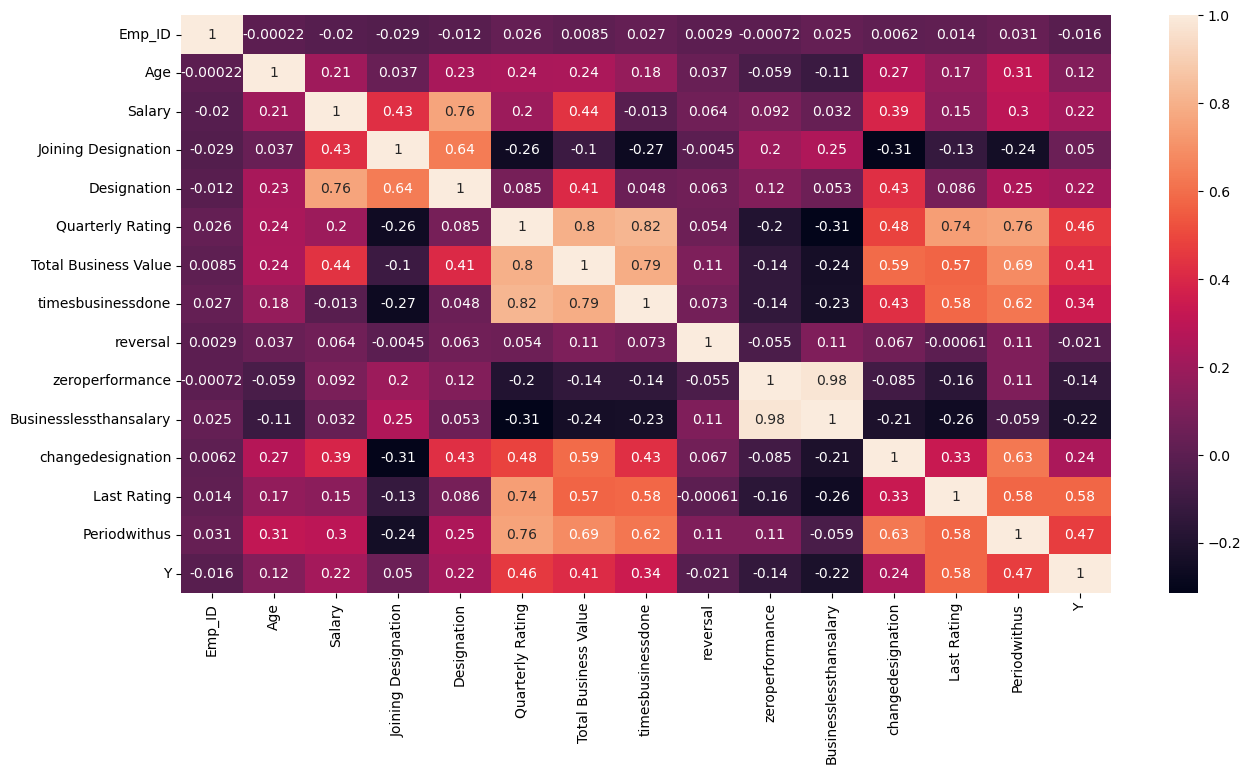

In [20]:
plt.figure(figsize=(15,7.5))
uniqueemployeesdata=uniqueemployeesdata[['Emp_ID', 'Age', 'City', 'Education_Level', 'Salary', 'Dateofjoining',
       'Joining Designation', 'Designation', 'Quarterly Rating',
       'Total Business Value', 'Gender',
       'timesbusinessdone','reversal','zeroperformance','Businesslessthansalary','changedesignation','Last Rating','Periodwithus','Y']]
df4_corr=uniqueemployeesdata.corr()
sns.heatmap(df4_corr,annot=True)

In [24]:
!pip install pycaret

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/eb/43/ec8d59a663e0a1a67196b404ec38ccb0051708bad74a48c80d96c61dd0e5/pycaret-3.2.0-py3-none-any.whl.metadata
  Using cached pycaret-3.2.0-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Obtaining dependency information for lightgbm>=3.0.0 from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
  Using cached lightgbm-4.1.0-py3-none-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.6.0-cp311-cp311-win_amd64.whl (7.2 MB)
  Obtaining dependency information for plotly-resampler>=0.8.3.1 from https://f

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\saray\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
Consider using the `--user` option or check the permissions.



# Model Evaluation

In [23]:
from pycaret.classification import *
s = setup(uniqueemployeesdata, target = 'Y', ignore_features = ['Emp_ID','Dateofjoining'])

SyntaxError: invalid syntax (1995545082.py, line 1)

In [22]:
best_model = compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8853,0.9519,0.8144,0.8801,0.8457,0.7546,0.7564,0.3530
rf,Random Forest Classifier,0.8970,0.9461,0.8144,0.9101,0.8590,0.7783,0.7818,0.3900
lightgbm,Light Gradient Boosting Machine,0.8875,0.9432,0.8046,0.8947,0.8467,0.7583,0.7615,0.1470
xgboost,Extreme Gradient Boosting,0.8902,0.9410,0.8193,0.8886,0.8519,0.7649,0.7671,19.1340
catboost,CatBoost Classifier,0.8736,0.9380,0.7685,0.8899,0.8244,0.7265,0.7316,2.0710
gbc,Gradient Boosting Classifier,0.8649,0.9197,0.7539,0.8805,0.8115,0.7073,0.7132,0.2720
ada,Ada Boost Classifier,0.8509,0.9096,0.7393,0.8557,0.7929,0.6775,0.6822,0.1030
lda,Linear Discriminant Analysis,0.8268,0.8742,0.7032,0.8245,0.7579,0.6245,0.6303,0.0240
dt,Decision Tree Classifier,0.8509,0.8413,0.7988,0.8136,0.8055,0.6848,0.6856,0.0180
nb,Naive Bayes,0.7287,0.7583,0.4267,0.7691,0.5475,0.3762,0.4101,0.0100


In [23]:
best_model

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=3163, verbose=0,
                     warm_start=False)

In [24]:
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8453,0.9271,0.7745,0.8144,0.7940,0.6702,0.6708
1,0.8453,0.9042,0.7549,0.8280,0.7897,0.6678,0.6696
2,0.8755,0.9330,0.7941,0.8710,0.8308,0.7326,0.7345
3,0.8679,0.9252,0.7549,0.8851,0.8148,0.7132,0.7186
4,0.8679,0.9319,0.8235,0.8317,0.8276,0.7206,0.7206
5,0.8377,0.9028,0.7255,0.8315,0.7749,0.6489,0.6526
6,0.8566,0.9224,0.7864,0.8351,0.8100,0.6950,0.6958
7,0.8415,0.9195,0.7476,0.8280,0.7857,0.6605,0.6627
8,0.8302,0.9173,0.7476,0.8021,0.7739,0.6382,0.6392
9,0.8604,0.9112,0.7573,0.8667,0.8083,0.6993,0.7032


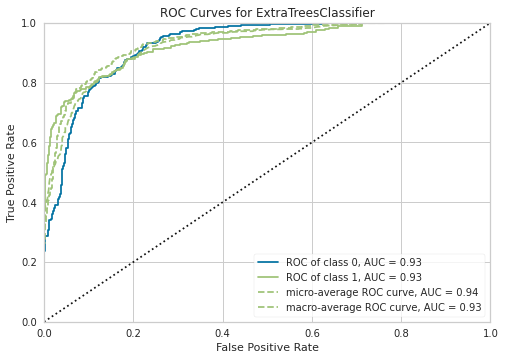

In [25]:
# performance of coverage
plot_model(tuned_best_model, plot = 'auc')

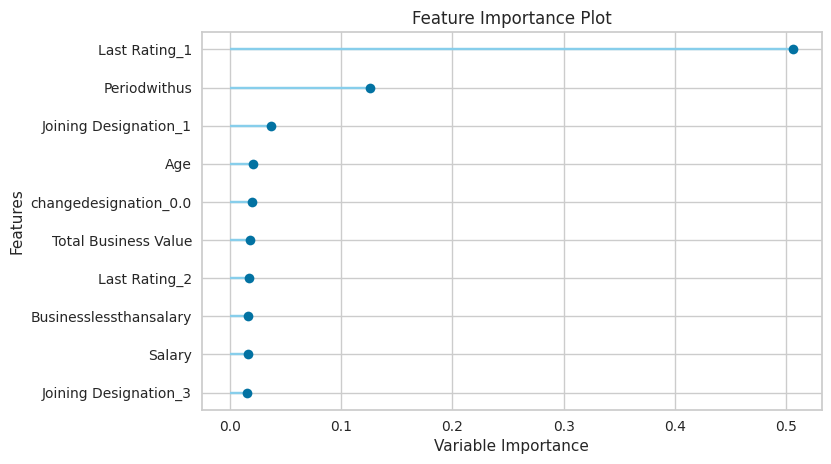

In [26]:
# feature importance
plot_model(tuned_best_model, plot = 'feature')

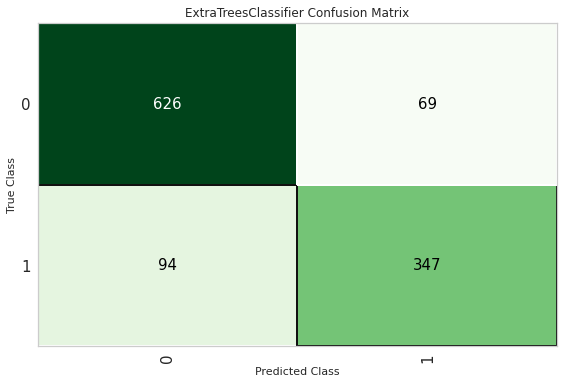

In [27]:
# confusion matrix
plot_model(tuned_best_model, plot = 'confusion_matrix')

In [28]:
test = pd.read_csv('/kaggle/input/predicting-employee-attrition/test_data.csv')

In [29]:
testset = uniqueemployeesdata[uniqueemployeesdata['Emp_ID'].isin(test['Emp_ID'])]
testset= testset.drop_duplicates()

In [30]:
et = create_model('et')
tuned_et = tune_model(et)
predict_model(tuned_et)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8453,0.9271,0.7745,0.8144,0.7940,0.6702,0.6708
1,0.8453,0.9042,0.7549,0.8280,0.7897,0.6678,0.6696
2,0.8755,0.9330,0.7941,0.8710,0.8308,0.7326,0.7345
3,0.8679,0.9252,0.7549,0.8851,0.8148,0.7132,0.7186
4,0.8679,0.9319,0.8235,0.8317,0.8276,0.7206,0.7206
5,0.8377,0.9028,0.7255,0.8315,0.7749,0.6489,0.6526
6,0.8566,0.9224,0.7864,0.8351,0.8100,0.6950,0.6958
7,0.8415,0.9195,0.7476,0.8280,0.7857,0.6605,0.6627
8,0.8302,0.9173,0.7476,0.8021,0.7739,0.6382,0.6392
9,0.8604,0.9112,0.7573,0.8667,0.8083,0.6993,0.7032


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8565,0.9274,0.7868,0.8341,0.8098,0.6948,0.6955


,Age,Salary,Quarterly Rating,Total Business Value,timesbusinessdone,Businesslessthansalary,Periodwithus,City_C1,City_C10,City_C11,...,zeroperformance_9.0,zeroperformance_not_available,changedesignation_0.0,Last Rating_1,Last Rating_2,Last Rating_3,Last Rating_4,Y,Label,Score
0,35.0,92372.0,2.000000,1.208662e+06,13.084719,4.0,18.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.9039
1,30.0,54971.0,1.000000,0.000000e+00,0.000000,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.6732
2,35.0,66350.0,2.625000,5.294771e+05,7.980062,1.0,24.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.6906
3,39.0,69098.0,2.846154,6.864839e+05,9.934931,1.0,13.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.9028
4,32.0,37617.0,1.600000,2.066060e+05,5.492357,2.0,5.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131,32.0,34356.0,1.000000,0.000000e+00,0.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.7672
1132,41.0,82617.0,1.000000,1.170767e+05,1.417101,1.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.6215
1133,32.0,68356.0,2.250000,1.445995e+06,21.153885,2.0,24.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.9052
1134,34.0,103060.0,1.000000,0.000000e+00,0.000000,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5168


In [31]:
final_et = finalize_model(tuned_et)
unseen_predictions = predict_model(final_et, data=testset)
predictionsfinal= unseen_predictions[['Emp_ID','Label']].drop_duplicates()

In [33]:
predictionsfinal.head()

,Emp_ID,Label
1,2,0.0
4,6,1.0
6,11,0.0
11,14,0.0
23,25,1.0


In [32]:
predictionsfinal = predictionsfinal.drop_duplicates( subset='Emp_ID',keep='last')
predictionsfinal.to_csv('predictions.csv')

Upvote, If you like the work. Thank you.